In [15]:
# Imports 
from cellpose import models
import tifffile as tiff
import numpy as np
import sys
import matplotlib.pyplot as plt
from skimage import measure
from skimage import io
from skimage.measure import label, regionprops
import os
import cv2
from cellpose import utils

# Parameters
nuclei_file = "Red opsin/2024-9-21/Red-pcdh15.tif"
puncta_stats_file = "Red opsin/2024-9-21/Statistics for C3-Red-pcdh15.oib - Series 1.csv"
mask_file = "Red opsin/2024-9-21/Red-pcdh15-do_3D_True-diameter_20-normalize_{'sharpen_radius': 0, 'normalize': True, 'percentile': [1, 99], 'tile_norm_blocksize': 50, 'norm3D': False}.tif"
volume_min = 1000
volume_max = 10000
boundaries = [200,300,600]
puncta_volume_min = 0
nuclear_expansion = 0

path = os.path.dirname(nuclei_file)
basename = os.path.basename(nuclei_file)
prefix = os.path.splitext(basename)[0]
summary_output_file = path + '/' + prefix + '_quantification.csv'
print('Output will be in :', summary_output_file)

Output will be in : Red opsin/2024-9-21/Red-pcdh15_quantification.csv


In [6]:
masks = tiff.imread(mask_file)
z_stack = tiff.imread(nuclei_file)

z_stack

array([[[ 684,  586, 2543, ...,  684,  782,  978],
        [ 293,  782,  391, ...,  978, 1075,  978],
        [ 880,  586,  880, ...,  293,  489,  880],
        ...,
        [ 880,  782, 1271, ..., 1369, 1075, 1075],
        [1173, 1075,  880, ...,  489,  489,  978],
        [1271, 1858,  978, ...,  684,  586,  489]],

       [[4653,  872,  290, ...,  678,  484,  193],
        [ 290,  290, 3005, ...,  484,  969,  484],
        [2132, 2714,  484, ...,  581,  581,  775],
        ...,
        [ 581,  290,  484, ...,  775,  678,  581],
        [ 872, 2908,  581, ...,  678,  484, 3683],
        [   0,  581,  484, ...,  872,  872,  581]],

       [[1899, 1044,  474, ...,  854,  759,  854],
        [1709, 1709, 3134, ...,  759, 1044,  569],
        [ 569, 2089, 2469, ...,   94, 2944,  474],
        ...,
        [ 474,  284,  569, ...,  379,  569,  854],
        [ 569,  759,    0, ...,  664,  949,  284],
        [ 949,  854,  474, ...,  379,  189,  379]],

       ...,

       [[ 409,  116,  11

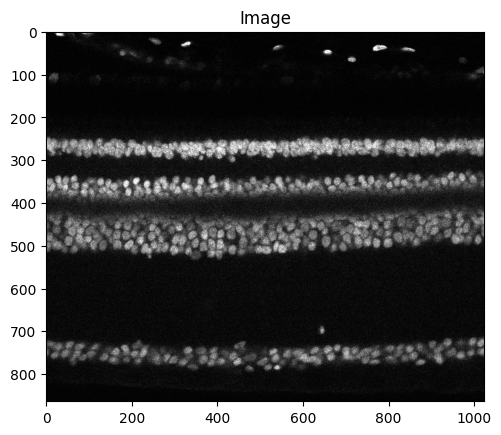

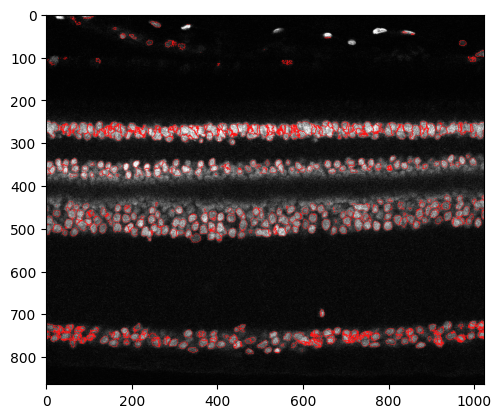

In [20]:
gray_image = z_stack[0]
scaled_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
rgb_image = cv2.cvtColor(scaled_image, cv2.COLOR_GRAY2RGB)
rgb_image
plot_image(rgb_image)
contour_image = rgb_image.copy()
outlines = utils.masks_to_outlines(masks[0])
outX, outY = np.nonzero(outlines)
contour_image[outX,outY] = np.array([255,20,20]) # Red
plt.imshow(contour_image)


Load functions

In [12]:
# Function to load the z-stack
def load_z_stack(file_path):
    try:
        z_stack = tiff.imread(file_path)
        # Check if the loaded image is a 3D array
        # if z_stack.ndim != 3:
        # raise ValueError("The loaded image is not a 3D z-stack.")
        print(f"Z-stack loaded successfully with shape {z_stack.shape}")
        return z_stack
    except Exception as e:
        print(f"Error loading z-stack: {e}")
        sys.exit(1)  # Exit if the image can't be loaded

def quick_segment(image, **kwargs):
    model = models.Cellpose(gpu=True, model_type='nuclei')
    masks, flows, styles, diams = model.eval(image, **kwargs)
    plot_two_images(image, masks)
    return masks

# Function to run Cellpose segmentation
def run_cellpose_segmentation(z_stack, **kwargs):
    # try:
        # Check if z-stack is non-empty
        if z_stack is None or not np.any(z_stack):
            raise ValueError("The z-stack is empty or invalid.")
        
        # Initialize the Cellpose model
        model = models.Cellpose(gpu=True, model_type='nuclei')
        
        # Run 3D segmentation
        masks, flows, styles, diams = model.eval(z_stack, **kwargs)
                                                 # diameter=20,
                                                 # channels=channels,
                                                 # do_3D=True)
                                                 # cellprob_threshold= -2, 
                                                 # normalize = True, 
                                                 # rescale = False
                                                 # flow_threshold=0.3 # unused in 3D
                                                 # mask_threshold=0.1 # doesn't exist?
                                                # )
        
        # Check if any masks were returned
        if masks is None or np.max(masks) == 0:
            raise ValueError("No segmentation masks were created.")
        
        print(f"Segmentation successful. Found {np.max(masks)} objects.")
        return masks
    # except Exception as e:
    #     print(f"Error during segmentation: {e}")
    #     sys.exit(1)  # Exit if segmentation fails

# Function to save the segmented z-stack
def save_segmented_z_stack(masks, output_file):
    try:
        tiff.imwrite(output_file, masks.astype('uint16'))
        print(f"Segmented z-stack saved successfully as {output_file}")
    except Exception as e:
        print(f"Error saving segmented z-stack: {e}")
        sys.exit(1)  # Exit if saving fails

def run_and_save_cellpose(z_stack_file, normalize_each = False, **kwargs):
    
    filename_parts = []
    
    # Iterate through the kwargs and create parts for the filename
    for key, value in kwargs.items():
        filename_parts.append(f"{key}_{value}")

    # Join the parts with underscores
    filename = "-".join(filename_parts)

    # Add a file extension (e.g., .txt)
    base_name = z_stack_file.split('.')[0]
    output_file = base_name + "-" + f"{filename}.tif"

    # Step 1: Load the z-stack
    z_stack = load_z_stack(z_stack_file)
    if(len(z_stack.shape) == 4):
        z_stack = z_stack[:,0,:,:] # DAPI channel

    # If normalize
    if(normalize_each):
        
        # Normalize each slice in the z-stack
        # If z-stack is 3D (z, height, width), we iterate over z
        # If z-stack is 4D (z, height, width, channels), you need to normalize per channel
        normalized_stack = np.zeros_like(z_stack)  # Create an empty array to store normalized images
        
        for z in range(z_stack.shape[0]):  # Iterate through each z-slice
            normalized_stack[z] = normalize_1_99(z_stack[z])

        # Check that it worked
        plot_two_images(z_stack[0], normalized_stack[0])
        breakpoint()
        z_stack = normalized_stack

    # Step 2: Run Cellpose segmentation
    segmented_masks = run_cellpose_segmentation(z_stack, **kwargs)
    
    # Step 3: Save the segmented result
    print(f"Writing output file to: {output_file}")
    save_segmented_z_stack(segmented_masks, output_file)

# Normalize each image slice between 0 and 1
def normalize_image(img):
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val > min_val:
        return (img - min_val) / (max_val - min_val)  # Normalize to [0, 1]
    else:
        return img  # If max == min, the image is constant, no need to normalize

def normalize_1_99(image):
    """
    Normalize the image based on the 1st and 99th percentiles.

    Args:
    - image (numpy array): The input image to be normalized.

    Returns:
    - normalized_image (numpy array): The normalized image.
    """
    # Calculate the 1st and 99th percentiles
    p1 = np.percentile(image, 1)
    p99 = np.percentile(image, 99)

    # Clip the image
    clipped_image = np.clip(image, p1, p99)

    # Normalize to the range 0-255 or 0-1
    normalized_image = (clipped_image - p1) / (p99 - p1)  # Scale to [0, 1]
    # normalized_image = normalized_image.astype(np.float32)
    normalized_image = (normalized_image * 255).astype(np.uint8)  # Scale to [0, 255] if needed

    return normalized_image
    
def plot_two_images(image1, image2, title1=None, title2=None):
    """
    Function to plot two images side by side using matplotlib.

    Args:
    - image1 (numpy array): The first image to be plotted.
    - image2 (numpy array): The second image to be plotted.
    - title1 (str): Optional. Title for the first image.
    - title2 (str): Optional. Title for the second image.

    Returns:
    None
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create 1x2 subplot
    
    # Plot first image
    axes[0].imshow(image1, cmap='gray', vmin = 0, vmax = 5000)
    axes[0].axis('off')  # Turn off axis for the first image
    if title1:
        axes[0].set_title(title1)
    
    # Plot second image
    axes[1].imshow(image2, cmap='gray')
    axes[1].axis('off')  # Turn off axis for the second image
    if title2:
        axes[1].set_title(title2)
    
    plt.tight_layout()  # Adjust layout so titles don't overlap
    plt.show()  # Display the plot


def check_masks(z_stack_file, mask_file, vmin = None, vmax = None):

    # Load the z-stack and masks
    if isinstance(z_stack_file, str):
        z_stack = load_z_stack(z_stack_file)
        if(len(z_stack.shape) == 4):
            z_stack = z_stack[:,0,:,:] # DAPI channel
    else: 
        z_stack = z_stack_file

    if isinstance(mask_file, str):
        masks = tiff.imread(mask_file)  # Load the corresponding masks from Cellpose
    else: 
        masks = mask_file
    
    # Select the number of slices to view
    num_slices_to_view = 10  # Adjust as needed
    total_slices = z_stack.shape[0]  # Get total number of slices
    
    # Generate a list of slice indices to view
    slice_indices = np.linspace(0, total_slices - 1, num_slices_to_view, dtype=int)
    
    # Set up the plot
    fig, axes = plt.subplots(num_slices_to_view, 2, figsize=(10, 4 * num_slices_to_view))
    
    global_min = min(np.min(img) for img in z_stack)
    global_max = max(np.max(img) for img in z_stack)
    if vmin is None:
        vmin = global_min
    if vmax is None:
        vmax = global_max
    
    # Loop through selected slices and display the original image and mask
    for i, slice_index in enumerate(slice_indices):
        # Display original z-stack slice
        axes[i, 0].imshow(z_stack[slice_index], cmap='gray', vmin = vmin, vmax = vmax)
        axes[i, 0].set_title(f'Original Slice {slice_index}')
        # axes[i, 0].axis('off')  # Hide axes for clarity
    
        # Display corresponding mask slice
        axes[i, 1].imshow(masks[slice_index], cmap='gray')  # cmap='jet', alpha=0.5)
        axes[i, 1].set_title(f'Mask Slice {slice_index}')
        # axes[i, 1].axis('off')  # Hide axes for clarity
    
    # Show the plots
    plt.tight_layout()
    plt.show()


def histogram(data_col, nbins = 10):
    
    # Create a histogram of the 'values' column
    plt.figure(figsize=(10, 6))  # Set the figure size
    data_col.hist(bins=nbins, color='skyblue', edgecolor='black')  # Create histogram
    
    # Customize the plot
    plt.title('Histogram of Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)  # Add gridlines for better readability
    # plt.xticks(range(1, 8))  # Set x-ticks based on the data range
    
    # Show the plot
    plt.show()

def scatterplot(x, y, title="Scatter Plot", xlabel="X-axis", ylabel="Y-axis"):
    """
    Creates a basic scatter plot.

    Parameters:
    x (list or array-like): Data for the X-axis.
    y (list or array-like): Data for the Y-axis.
    title (str): Title of the scatter plot (default is "Scatter Plot").
    xlabel (str): Label for the X-axis (default is "X-axis").
    ylabel (str): Label for the Y-axis (default is "Y-axis").
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', alpha=0.7)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.grid(True)
    plt.show()

def plot_image(image, title="Image"):
    """
    Plots an image using matplotlib.

    Parameters:
    image (ndarray): The image data (can be grayscale or RGB).
    title (str): The title of the image plot.
    """
    plt.imshow(image, cmap='gray')
    plt.title(title)
    # plt.axis('off')  # Hide axes ticks and labels
    plt.show()


# Run cellpose on nuclei

In [ ]:
run_and_save_cellpose(nuclei_file, 
                      normalize_each = False, 
                      do_3D = True, 
                      diameter = 20, 
                      normalize = {#"lowhigh":[155, 4095], 
                                   "sharpen_radius":0,
                                   # "smooth_radius":1,
                                   "normalize": True, 
                                   "percentile":[1, 99], 
                                   "tile_norm_blocksize":50,
                                   "norm3D":False})

check_masks(nuclei_file, mask_file)

Z-stack loaded successfully with shape (82, 864, 1024)


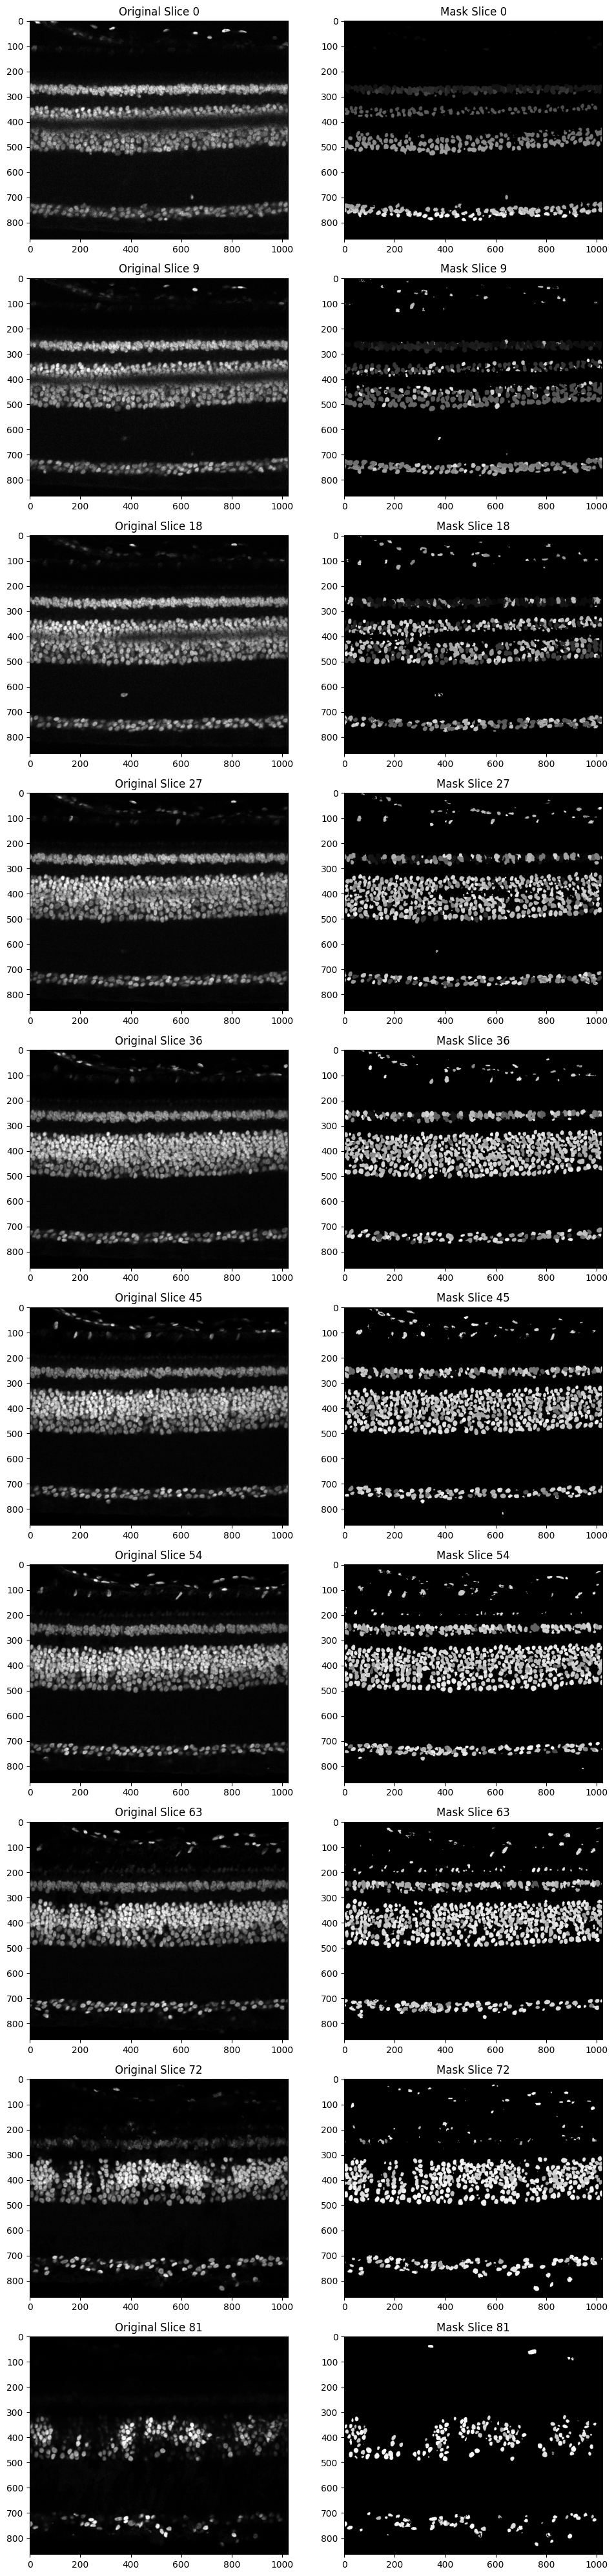

In [17]:
# enhance contrast on each slice in Fiji first
check_masks(nuclei_file, mask_file)


# Puncta counting

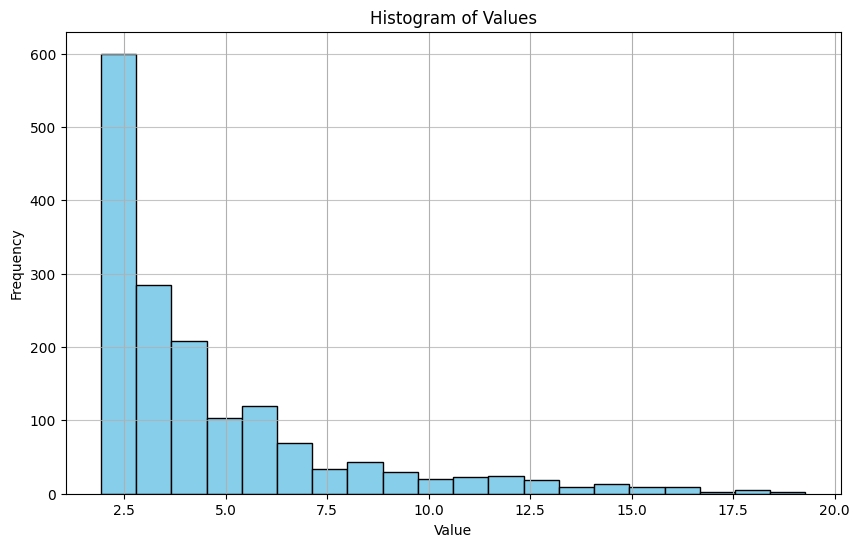

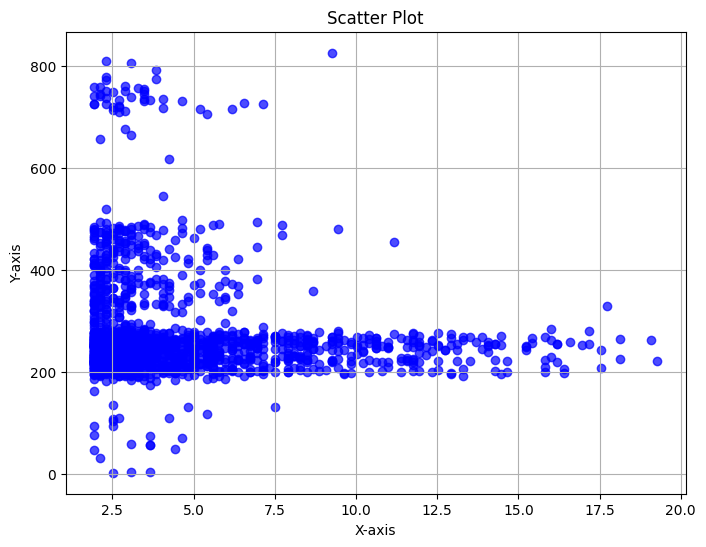

In [18]:
# Make parquet file
import pandas as pd
import numpy as np

# Create a sample pandas DataFrame
signal_df = pd.read_csv(puncta_stats_file)
# print(signal_df.head())

# signal_df[['Volume (micron^3)']]
histogram(signal_df['Volume (micron^3)'], nbins = 20)
scatterplot(signal_df['Volume (micron^3)'], signal_df['Y'])

signal_df['transcript_id'] = list(range(1, signal_df.shape[0]+1))
signal_df['cell_id'] = -1
signal_df['overlaps_nucleus'] = 0
signal_df['feature_name'] = 'OPN1LW' #['signal_' + str(i) for i in list(range(1, signal_df.shape[0]+1))]
signal_df['x_location'] = signal_df['X']
signal_df['y_location'] = signal_df['Y']
signal_df['z_location'] = signal_df['Z']
signal_df['qv'] = 40
signal_df.head()

# Remove signal with volume less than this number
signal_df = signal_df[signal_df['Volume (micron^3)'] > puncta_volume_min]

# Should be: transcript_id  cell_id  overlaps_nucleus feature_name  x_location  y_location  z_location
signal_df2 = signal_df.loc[:, ['transcript_id', 'cell_id', 'overlaps_nucleus', 'feature_name', 'x_location', 'y_location', 'z_location', 'qv']]
signal_df2 = signal_df2.astype({'transcript_id':np.uint64, 
                                'cell_id':np.int32, 
                                'overlaps_nucleus':np.uint8, 
                                'feature_name':object, 
                                'x_location':np.float32, 
                                'y_location':np.float32, 
                                'z_location':np.float32, 
                                'qv':np.float32})

# Write the DataFrame to a Parquet file
signal_df2.to_parquet('signal.parquet', engine='pyarrow')
# print(signal_df2.dtypes)
# print(signal_df2.head())

# Types should be: 
# transcript_id        uint64
# cell_id               int32
# overlaps_nucleus      uint8
# feature_name         object
# x_location          float32
# y_location          float32
# z_location          float32
# qv                  float32


In [19]:
!python map_transcripts.py --help

usage: map_transcripts.py [-h] -cellpose CELLPOSE -transcript TRANSCRIPT -out
                          OUT -pix_size PIX_SIZE [-nuc_exp NUC_EXP]
                          [-qv_cutoff QV_CUTOFF] [-rep_int REP_INT]

Map Xenium transcripts to Cellpose segmentation result. Generate
Seurat/Scanpy-compatible feature-cell matrix.

options:
  -h, --help            show this help message and exit
  -nuc_exp NUC_EXP      The expansion distance from the nuclear boundary, in
                        microns, for cell boundary. (default: 10.0)
  -qv_cutoff QV_CUTOFF  Ignore transcripts with QV score below this threshold.
                        (default: 20.0)
  -rep_int REP_INT      Reporting interval. Will print message to stdout
                        whenever the specified # of transcripts is processed.
                        (default: 10000)

required named arguments:
  -cellpose CELLPOSE    The path to the *.ome_seg.npy file produced by
                        Cellpose.
  -transcript TRANSC

In [20]:
# !source activate cellpose
!rm -r feature_cell_matrix
!python map_transcripts.py -cellpose "{mask_file}" -transcript signal.parquet -out feature_cell_matrix -pix_size 0.6210004 -nuc_exp {nuclear_expansion} -rep_int 50


0 transcripts processed.
50 transcripts processed.
100 transcripts processed.
150 transcripts processed.
200 transcripts processed.
250 transcripts processed.
300 transcripts processed.
350 transcripts processed.
400 transcripts processed.
450 transcripts processed.
500 transcripts processed.
550 transcripts processed.
600 transcripts processed.
650 transcripts processed.
700 transcripts processed.
750 transcripts processed.
800 transcripts processed.
850 transcripts processed.
900 transcripts processed.
950 transcripts processed.
1000 transcripts processed.
1050 transcripts processed.
1100 transcripts processed.
1150 transcripts processed.
1200 transcripts processed.
1250 transcripts processed.
1300 transcripts processed.
1350 transcripts processed.
1400 transcripts processed.
1450 transcripts processed.
1500 transcripts processed.
1550 transcripts processed.
1600 transcripts processed.


In [21]:
import gzip
import numpy as np
from scipy.io import mmread
import pandas as pd

# Path to the gzipped .mtx file
file_path = 'feature_cell_matrix/matrix.mtx.gz'

# Read the gzipped Matrix Market file
with gzip.open(file_path, 'rb') as f:
    matrix = mmread(f).toarray()  # Convert to a NumPy array

print(matrix)

barcodes = [int(cell.split('_')[1]) for cell in pd.read_csv('feature_cell_matrix/barcodes.tsv.gz', delimiter='\t', compression='gzip', header = None).iloc[:,0]]

non_zero_count = np.count_nonzero(matrix)

print("Number of non-zero entries:", non_zero_count)
print(matrix.max())
print(matrix.shape)
barcodes[0:5]

# Check if results make sense
z_stack = tiff.imread(mask_file)

unique_values = np.unique(z_stack)
print("Unique values:", unique_values)

# Let's highlight the positive cells, as these should be mainly in photoreceptor layer!
# z_stack[
# matrix[np.where(matrix != 0)]

positive_cells = [barcodes[i] for i in np.where(matrix != 0)[1].tolist()]
positive_cells

positive_mask = np.zeros_like(z_stack)
positive_mask[np.isin(z_stack, positive_cells)] = 1
positive_mask

print("Unique values:", np.unique(positive_mask))


[[0 0 0 ... 0 0 0]]
Number of non-zero entries: 388
8
(1, 5120)
Unique values: [   0    1    2 ... 5118 5119 5120]
Unique values: [0 1]


5120
  Region 1:
  Label: 1
  Area: 88.0
  Centroid: (2.4545454545454546, 3.8863636363636362, 105.9659090909091)
  Bounding Box: (0, 0, 103, 8, 9, 108)

  Region 2:
  Label: 2
  Area: 94.0
  Centroid: (2.425531914893617, 3.1702127659574466, 108.79787234042553)
  Bounding Box: (0, 0, 108, 7, 7, 112)

  Region 3:
  Label: 3
  Area: 599.0
  Centroid: (6.130217028380635, 5.67779632721202, 57.235392320534224)
  Bounding Box: (0, 0, 52, 12, 14, 65)

  Region 4:
  Label: 4
  Area: 79.0
  Centroid: (5.670886075949367, 2.9240506329113924, 63.29113924050633)
  Bounding Box: (0, 0, 61, 11, 7, 66)

  Region 5:
  Label: 5
  Area: 750.0
  Centroid: (6.06, 11.737333333333334, 64.252)
  Bounding Box: (0, 0, 54, 18, 21, 72)

  Region 6:
  Label: 6
  Area: 577.0
  Centroid: (4.902946273830156, 7.665511265164644, 93.40207972270363)
  Bounding Box: (0, 4, 82, 11, 12, 107)

  Region 7:
  Label: 7
  Area: 83.0
  Centroid: (5.819277108433735, 8.44578313253012, 59.602409638554214)
  Bounding Box: (0, 1, 54, 1

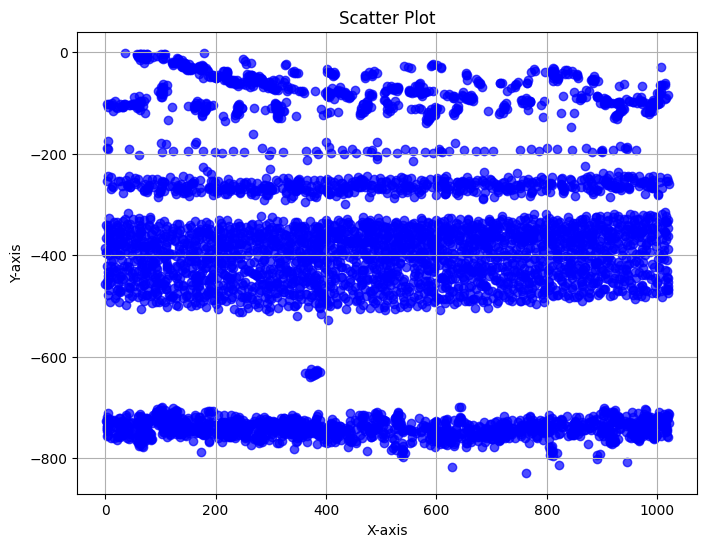

In [22]:
# Find all the centroids

# Measure the properties of the labeled regions
regions = regionprops(z_stack)
print(len(regions))

# Print out properties for each region
for i, region in enumerate(regions[0:9]):
    print(f'  Region {i + 1}:')
    print(f'  Label: {region.label}')
    print(f'  Area: {region.area}')
    print(f'  Centroid: {region.centroid}')
    print(f'  Bounding Box: {region.bbox}')
    # print(f'  Eccentricity: {region.eccentricity}')
    # print(f'  Orientation: {region.orientation}')  
    print()

# Scatterplot of centroids
scatterplot([region.centroid[2] for region in regions], [-region.centroid[1] for region in regions])

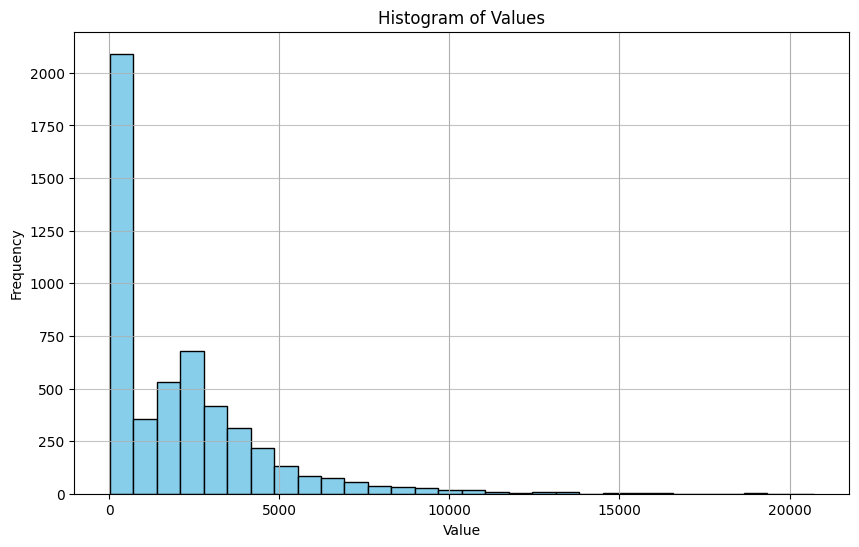

    cell           x          y          z  volume  positive    ONL    INL  \
7      8   74.147214  13.749247  13.739081  2656.0     False  False  False   
9     10  254.667556  22.223111   2.400889  1125.0     False  False  False   
13    14  158.659948  33.960988   6.507152  1538.0     False  False  False   
17    18  177.579389  50.608397   4.706107  1310.0     False  False  False   
21    22  170.247830  43.570245  21.289661  2534.0     False  False  False   

      GCL  
7   False  
9   False  
13  False  
17  False  
21  False  
Found  2796  total cells!
Found  284  cells in ONL!
Found  1986  cells in INL!
Found  426  cells in GCL!
Found  169  positive cells in ONL!
Found  127  positive cells in INL!
Found  18  positive cells in GCL!
Found  0.5950704225352113 % positive cells in ONL!
Found  0.06394763343403827 % positive cells in INL!
Found  0.04225352112676056 % positive cells in GCL!


In [23]:
# Photoreceptor selection based on size 

# Criteria: centroid in 250-300, volumn is reasonable ~(20 px X 20 px X 20 px)
cell_metadata = pd.DataFrame({'cell': [region.label for region in regions], 
                             'x': [region.centroid[2] for region in regions], 
                             'y': [region.centroid[1] for region in regions], 
                             'z': [region.centroid[0] for region in regions],
                             'volume': [region.area for region in regions],
                             'positive': [region.label in positive_cells for region in regions]
                             })

histogram(cell_metadata['volume'], nbins = 30)

good_cell_metadata = cell_metadata[(cell_metadata['volume'] > volume_min) & (cell_metadata['volume'] < volume_max)].copy()

# histogram(good_cell_metadata['volume'], nbins = 30)
# scatterplot(good_cell_metadata['x'], -good_cell_metadata['y'])
good_cell_metadata.loc[:, 'ONL'] = (good_cell_metadata['y'] < boundaries[1]) & (good_cell_metadata['y'] > boundaries[0])
good_cell_metadata.loc[:, 'INL'] = (good_cell_metadata['y'] < boundaries[2]) & (good_cell_metadata['y'] > boundaries[1])
good_cell_metadata.loc[:, 'GCL'] = (good_cell_metadata['y'] > boundaries[2])

# scatterplot(photoreceptor_metadata['x'], -photoreceptor_metadata['y'])
print(good_cell_metadata.head())
print("Found ", good_cell_metadata.shape[0], " total cells!")
print("Found ", good_cell_metadata['ONL'].sum(), " cells in ONL!")
print("Found ", good_cell_metadata['INL'].sum(), " cells in INL!")
print("Found ", good_cell_metadata['GCL'].sum(), " cells in GCL!")
print("Found ", (good_cell_metadata['ONL'] & good_cell_metadata['positive']).sum(), " positive cells in ONL!")
print("Found ", (good_cell_metadata['INL'] & good_cell_metadata['positive']).sum(), " positive cells in INL!")
print("Found ", (good_cell_metadata['GCL'] & good_cell_metadata['positive']).sum(), " positive cells in GCL!")
print("Found ", (good_cell_metadata['ONL'] & good_cell_metadata['positive']).sum()/good_cell_metadata['ONL'].sum(), "% positive cells in ONL!")
print("Found ", (good_cell_metadata['INL'] & good_cell_metadata['positive']).sum()/good_cell_metadata['INL'].sum(), "% positive cells in INL!")
print("Found ", (good_cell_metadata['GCL'] & good_cell_metadata['positive']).sum()/good_cell_metadata['GCL'].sum(), "% positive cells in GCL!")

good_cell_metadata.to_csv(summary_output_file)

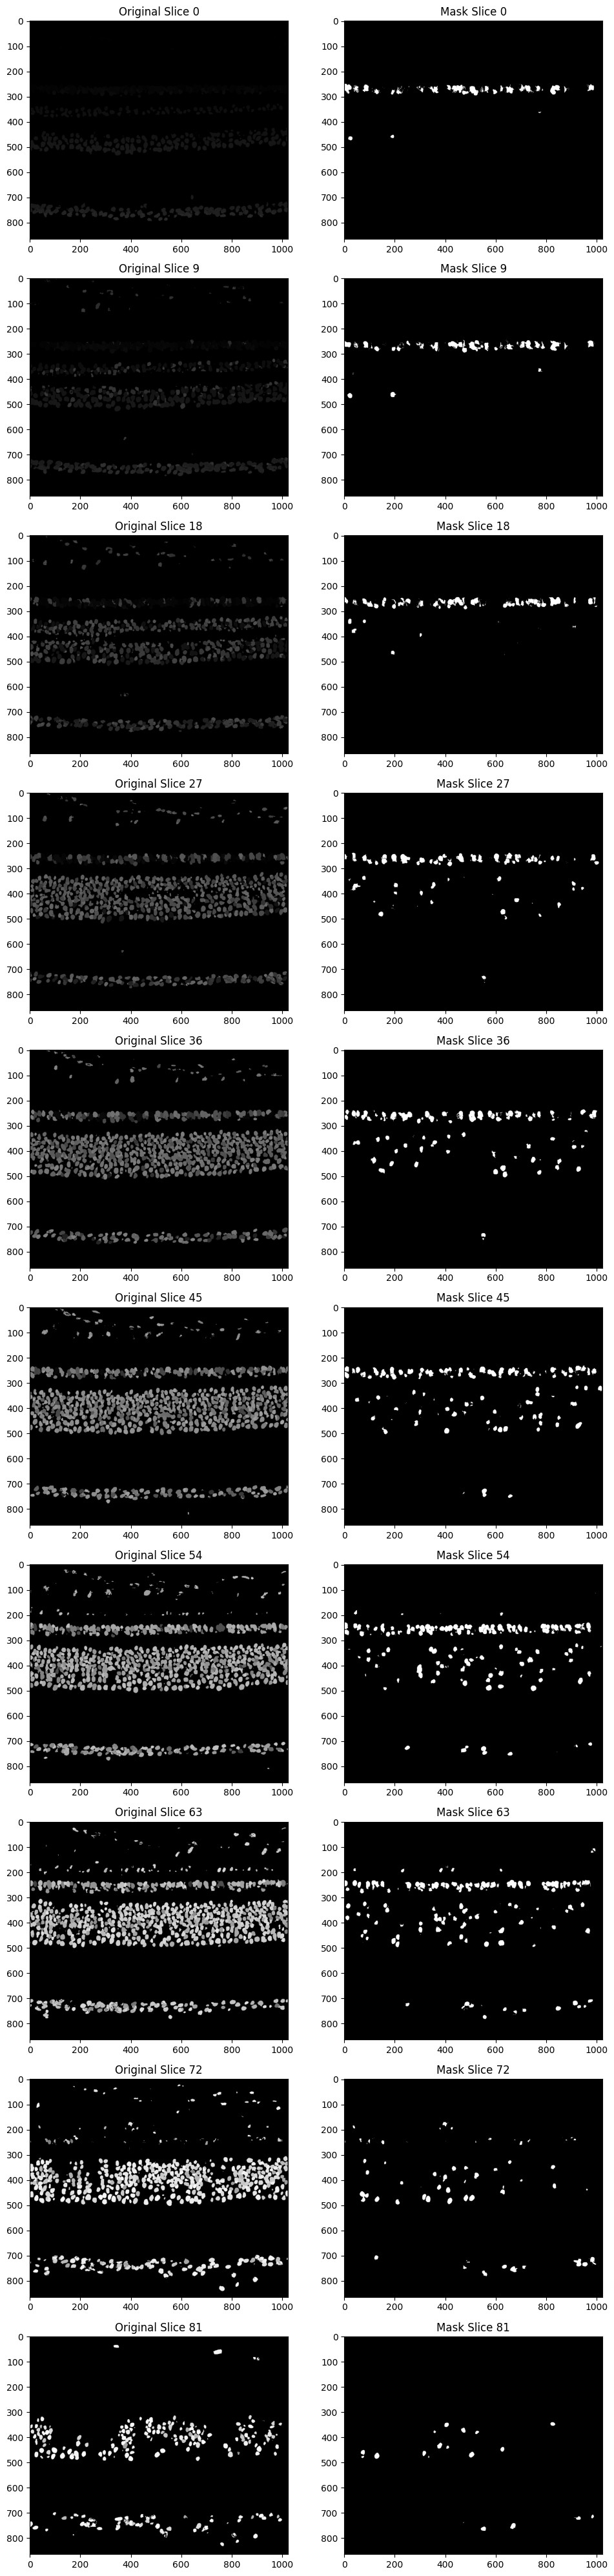

In [24]:
positive_mask = np.zeros_like(z_stack)
positive_cells = good_cell_metadata[good_cell_metadata['positive']]['cell'].to_list()
positive_mask[np.isin(z_stack, positive_cells)] = 1
check_masks(z_stack, positive_mask)

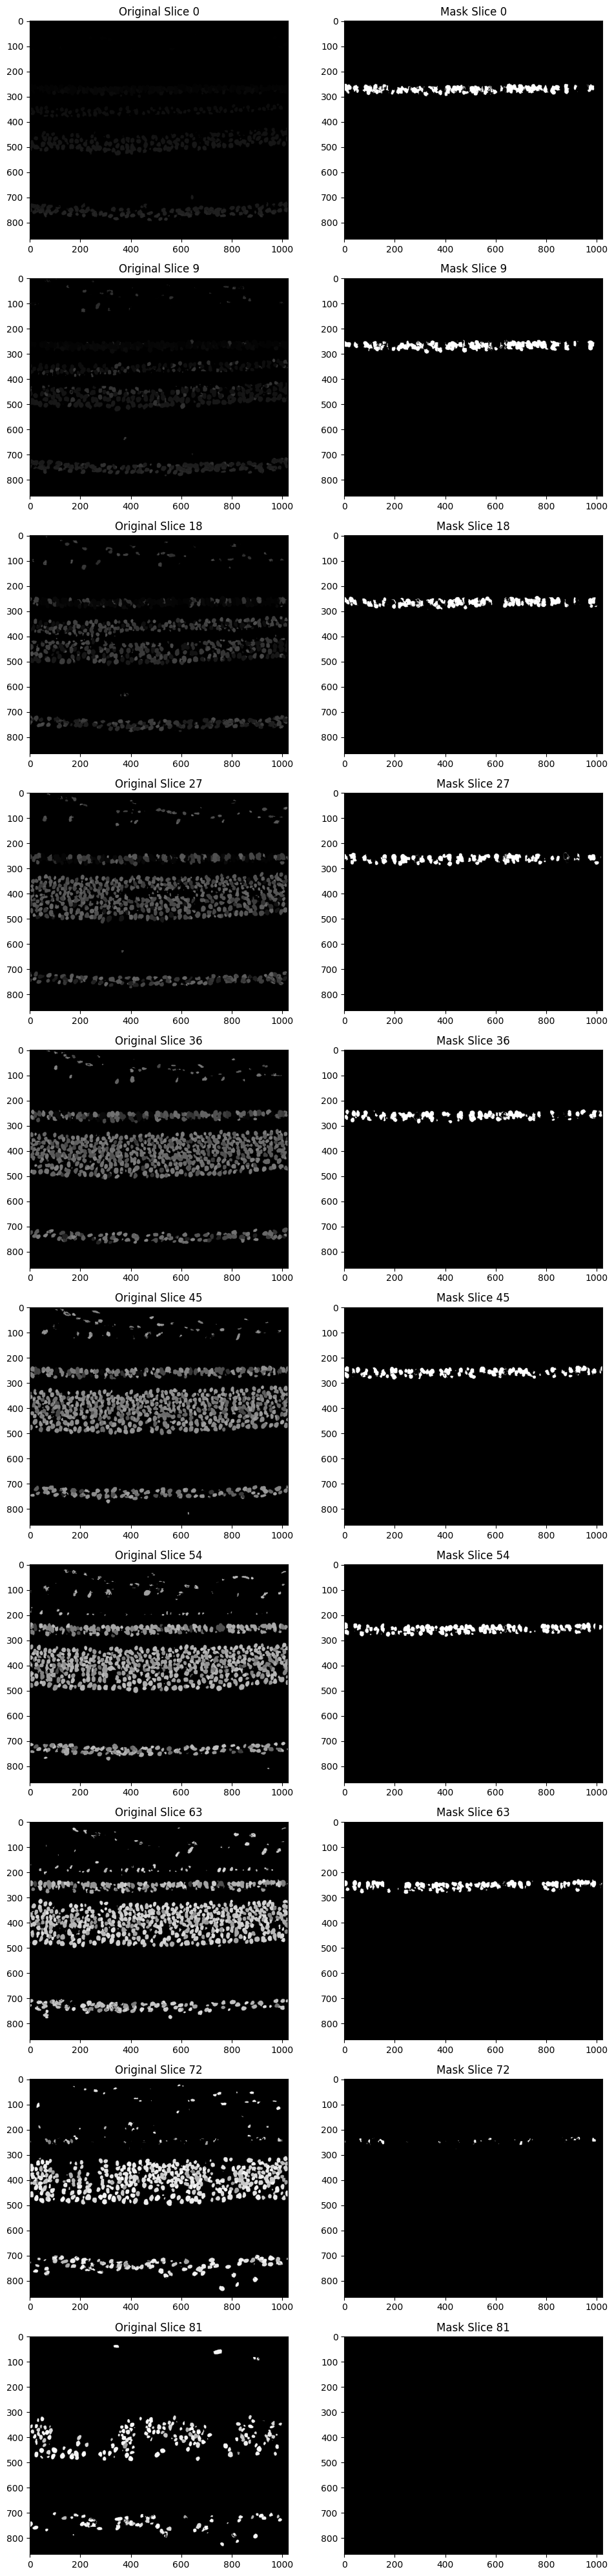

In [25]:
photoreceptor_mask = np.zeros_like(z_stack)
photoreceptor_cells = good_cell_metadata[good_cell_metadata['ONL']]['cell']
photoreceptor_mask[np.isin(z_stack, photoreceptor_cells)] = 1
check_masks(z_stack, photoreceptor_mask)

Positive photoreceptors:  169


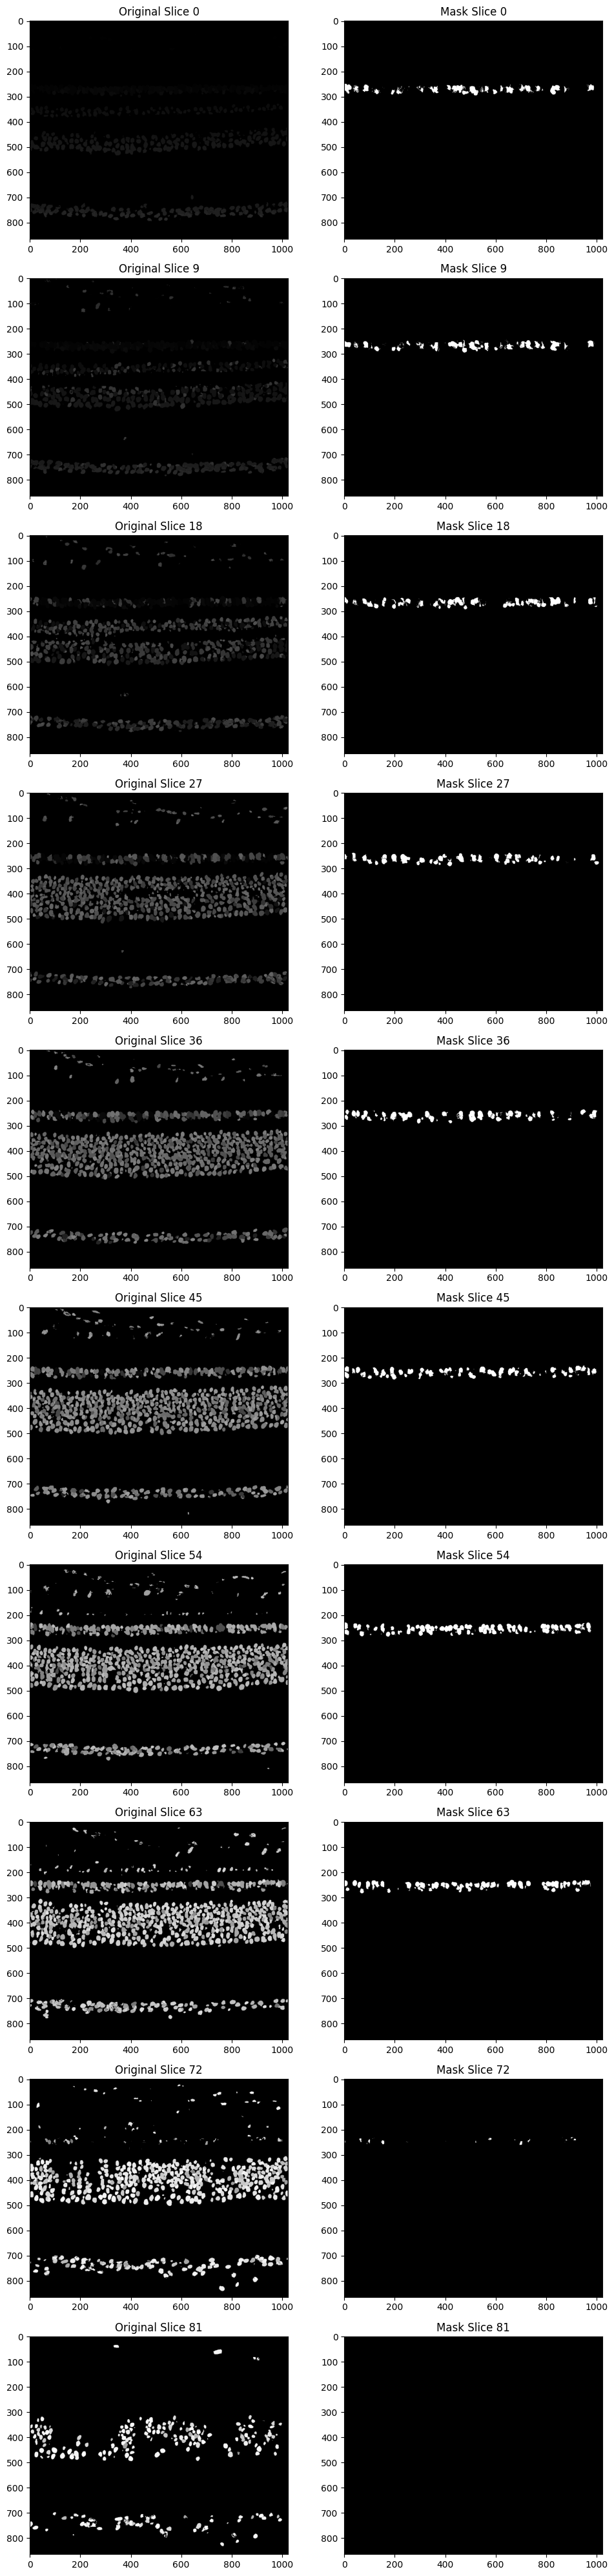

In [26]:
positive_pr_mask = np.zeros_like(z_stack)
positive_pr_cells = good_cell_metadata[good_cell_metadata['positive'] & good_cell_metadata['ONL']]['cell']
positive_pr_mask[np.isin(z_stack, positive_pr_cells)] = 1
print("Positive photoreceptors: ", len(positive_pr_cells))
check_masks(z_stack, positive_pr_mask)